# lens modellingh of SDSS1206+4332 with multiple options
This notebooks takes the data and psf configurations of the pre-analysis and configures (and runs) the lens modelling and parameter inference.
There are two modes:
    - local execution of a single model: this is mostly to test a model and having an output in a finite time. Thius is the default setting of this notebook.
    - cluster compute: it sends the configuration files to a cluster where the same models can be executed on multiple cores. This is the mode the results were produced.
    
In the second mode, the notebook initializes all the models that have been included in the analysis of Birrer et al. 2018.
In the last blocks of the notebook, some quick model inspections are performed.

### import libraries

In [1]:
# import libraries
import numpy as np
import os
import pickle
import copy
import time

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import lenstronomy.Plots.output_plots as out_plot

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

/Users/sibirrer/Science/Projects/LensModelling/SDSS1206/Public


In [2]:
# set up the Data() and PSF() class of lenstronomy

import h5py
# import the data
data_file = os.path.join(base_path, 'Data', 'HST', 'data.hdf5')
f = h5py.File(data_file, 'r')
data_reduced = f['image_data'][()]
background_rms = f['background_rms'][()]
exposure_map = f['exposure_map'][()]
ra_at_xy_0 = f['ra_at_xy_0'][()]
dec_at_xy_0 = f['dec_at_xy_0'][()]
transform_pix2angle = f['transform_pix2angle'][()]
f.close()

kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_map': exposure_map,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle,
                    }

# get data and PSF estimate from file
psf_file = os.path.join(base_path, 'Data', 'HST', 'psf.hdf5')
f = h5py.File(psf_file, 'r')
kernel_point_source = f['kernel_point_source'][()]
psf_error_map = f['psf_error_map'][()]
f.close()


kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                   'psf_error_map': psf_error_map,
                   'psf_error_map_init': psf_error_map
                  }


## show image and initial guesses of point source coordinates

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


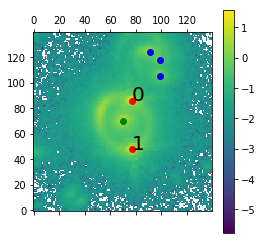

0.07998115006475026


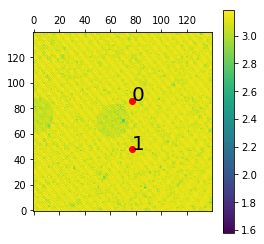

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10


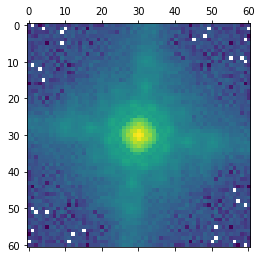

In [3]:
# read-in the coordiante system of the exposure
from lenstronomy.Data.coord_transforms import Coordinates
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data['image_data']
numPix = len(data_cutout)

plt.matshow(np.log10(data_cutout), origin='lower')
plt.autoscale(False)

# estimate point source positions in (ra/dec)
im_pos_ra = np.array([ -0.55917549, -0.56050771])
im_pos_dec = np.array([ 1.28024453, -1.75975331])
lens_center_ra, lens_center_dec = 0., 0.

# set the luminous satellite position
ra_sat, dec_sat = -0.11536459274976199, 0.91898834920946271

# set the perturber galaxy central positions
ra_pert = [-2.32019894, -2.32019933, -1.68019931, 6.63612394, 6.07970227] 
dec_pert = [ 2.79985456,  3.83985426,  4.31985428, -2.08278664, 5.83744312]

# flux values (arbitrary units) of the perturber galaxies (this has been estimated independently on the HST images)
flux_pert = [145.19774956059135, 63.79016370630126, 320.18619968879653, 112.77441486726345, 80.21861599639342]

x_pert, y_pert = coords.map_coord2pix(ra_pert, dec_pert)
x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)
plt.plot(x_pert, y_pert, 'ob')
x_image, y_image = coords.map_coord2pix(im_pos_ra, im_pos_dec)
plt.plot(x_image, y_image, 'or')
for i in range(len(x_image)):
    plt.text(x_image[i], y_image[i], i, fontsize=20)
plt.plot(x_at_radec_0, y_at_radec_0, 'og')    
plt.colorbar()
plt.show()

deltaPix = coords.pixel_size
print(deltaPix)
x_coords, y_coords = coords.coordinate_grid(numPix)
wht_map = kwargs_data['exposure_map']

plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)


plt.plot(x_image,y_image,'or')
for i in range(len(x_image)):
    plt.text(x_image[i], y_image[i], i, fontsize=20)
plt.colorbar()
plt.show()

psf_kernel = kwargs_psf['kernel_point_source']
plt.matshow(np.log10(psf_kernel), vmin=-6)
plt.show()



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10


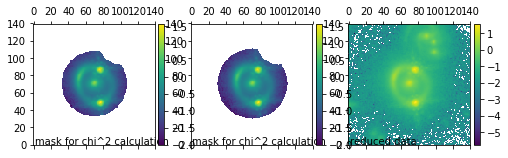

In [4]:
# set the two masking regions used in the analysis

import lenstronomy.Util.mask as mask_util

object_off_x, object_off_y = coords.map_pix2coord(90+10, 107+10)
mask_off = 1 - mask_util.mask_center_2d(object_off_x, object_off_y, 2., util.image2array(x_coords), util.image2array(y_coords))

r_mask_list = [3, 3.2]
mask_list = []
for r in r_mask_list:
    mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
    idex_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, 3.5, util.image2array(x_coords), util.image2array(y_coords))
    mask_i = (1 - mask_outer) - mask_off
    mask_i[mask_i > 1] = 1
    mask_i[mask_i < 0] = 0
    mask_list.append(mask_i)

    
f, axes = plt.subplots(1, len(r_mask_list)+1, figsize=(8, 4), sharex=False, sharey=False)
for i in range(len(r_mask_list)):
    ax = axes[i]
    mask_i = mask_list[i]
    im = ax.matshow(np.log10(data_cutout*mask_i), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

ax = axes[i+1]
im = ax.matshow(np.log10(data_cutout), origin='lower')
ax.text(1, 1, 'reduced data')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()


### Options for lenstronomy
- mask_list (larger, smaller): 2
- perturber lens model (SIS, SIE, NFW): 3
- source description (double Sersic, + n_max=2, +n_max=5, +n_max=8): 4
- foreground shear (False, True): 2

In [5]:
ssh_command = 'sibirrer@hoffman2.idre.ucla.edu'
dir_path = os.getcwd()
dir_path_cluster = '/u/flashscratch/s/sibirrer/'

shapelet_beta = 0.15  # initial guess of the shapelet scale (in arcsec)

psf_iteration = True  # bool, we perform an iterative PSF reconstruction
psf_iter_num = 200  # number of steps in the PSF reconstruction
psf_iter_factor = 0.5  # factor of f* new + (1-f)* old PSF in each iterative step
psf_symmetry = 4  # number of symmetry axis rotations

shear = True  # adding of a external shear component in the model
flexion = False  # addition of explicit flextion terms in the model
with_satellite = True  # adding satellite galaxies in the model

group_halo = False  # additon an additonal group halo in addition to the main deflector
mass_scaling = True  # keep mass scaling fixed for external perturbers
mass_light_scatter_dex = 0.1  # scatter in the M/L ratio of the external perturbers
composite_type = 'DOUBLE_CHAMELEON'  # 'CHAMELEON', 'MGE', 'INTERPOL', 'DOUBLE_CHAMELEON'
mass_light_joint = True  # joint mass and light parameters in the composite model option


point_source_model_list = ['LENSED_POSITION']  # we model the point sources in the image plane

n_p_short = 100  # number of particles in the PSO (for tests)
n_i_short = 200  # number of iterations of the PSO (for tests)
n_p_long = 200  # number of particles in the PSO 
n_i_long = 400  # number of iterations of the PSO 


def configure_model(job_name, lens_model, perturber_model, mask, n_max, foreground_shear, subgrid_res, num_perturber, group_halo=False, cluster_compute=True):
    """
    this definitons takes as an input some specific options that are varried in the modelling and merges them
    with the other choices made and runs the modeling and parameter inference
    
    job_name: string, the file with its specific configuration will be named that way
    lens_model: string: 'composite', 'SPEMD' as options
    perturber_model: string, type of model for the perturbers ('SIS', 'SIE', 'NFW', ...)
    mask: 2d numpy array, masking region of fit
    n_max: maximal polynomial order of shapelets in the source plane
    foreground_shear: bool, if True, adds a foreground shear model
    subgrid_res: subsampling of the surface brightness of pixels
    num_perturber: integer, number of perturbers being modeled (in subsequent order of the defined list above)
    group_halo: bool, additon an additonal group halo in addition to the main deflector
    cluser_compute: bool, if True, instead of running the chain, saves and copies the configuration files to a cluster
    """
    n_max_start = -1  # we start with a simple model (without shapelets) and then later no in the fit add complexity if required
    with_shapelets = True
    triple_type = perturber_model
    deflector_model = lens_model  # 'composite', 'SPEMD'
    #lens_model = 'SPEMD'  # 'NFW_SERSIC', 'NFW_PJAFFE', 'SPEMD', 'COMPOSITE', 'NFW_SERSIC_DOUBLE'

    # here we though the dice in the M/L scatter relation and fix then the relative amplitude of the Einstein radii of the external perturbers
    flux_pert_scatter = 10**(np.log10(flux_pert) + np.random.normal(loc=0, scale=mass_light_scatter_dex, size=len(flux_pert)))
    # convert flux to Einstein radius (see paper)
    theta_E_pert = np.sqrt(flux_pert_scatter)
    # for convenience, we normalize the Einstein radii to set the maximal value to 0.2. In the fit, the overall amplitude is a free parameter.
    theta_E_pert /= np.max(theta_E_pert)
    theta_E_pert *= 0.2
    theta_E_pert_list = theta_E_pert

    lens_model_list = []
    lens_model_deflector_bool = []

    source_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']  # 'SHAPELETS', 'DOUBLE_SERSIC'
    if with_shapelets:
        source_light_model_list.append('SHAPELETS')
    if deflector_model == 'composite':
        lens_light_model_list = ['DOUBLE_CHAMELEON', 'UNIFORM']  # 'HERNQUIST_ELLIPSE', 'PJAFFE_ELLIPSE', 'DOUBLE_SERSIC', 'CHAMELEON', 'DOUBLE_CHAMELEON'
    else:
        lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'UNIFORM']
    light_model_deflector_bool = [True] * len(lens_light_model_list)
    light_model_deflector_bool[-1] = False


    
    #  ======================================================  #
    #  SPECIFY PARAMETER CONSTRAINTS  #
    #  ======================================================  #


    # lens models
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []
    mass_scaling_list = []
    joint_with_light_list = []


    if deflector_model == 'SPEMD':
            mass_scaling_list.append(False)
            lens_model_list.append('SPEMD')
            lens_model_deflector_bool.append(True)
            fixed_lens.append({})
            kwargs_lens_init.append({'theta_E': 1.5, 'e1': 0, 'e2': 0, 'gamma': 2., 
                                 'center_x': lens_center_ra, 'center_y': lens_center_dec})
            kwargs_lens_sigma.append({'theta_E': .2, 'e1':0.1, 'e2':0.1, 'gamma': 0.2
                        , 'center_x': 0.1, 'center_y': 0.1})
            kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 
                                 'center_x': -10, 'center_y': -10})
            kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 
                                 'center_x': 10, 'center_y': 10})
    elif deflector_model == 'composite':
        # Sersic fit to the lens light profile
        lens_model_list.append('NFW_ELLIPSE')
        lens_model_deflector_bool.append(True)
        mass_scaling_list.append(False)
        sersic_lens = {'n_sersic': 5.3809697450303835, 'center_x': -0.0015653120745398427, 'center_y': 0.05678130863602721, 'r_eff': 0.41217361578131523}
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_Rs': .8, 'Rs': 5., 'center_x': -0.0015653120745398427, 'center_y': 0.05678130863602721, 'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'theta_Rs': 0.5, 'Rs': 2., 'center_x': 0.1, 'center_y': 0.1, 'e1':0.2, 'e2':0.2})
        kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': 2., 'center_x': lens_center_ra-0.2, 'center_y': lens_center_dec-0.2, 'e1': -0.5, 'e2': -0.5})
        kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 30, 'center_x': lens_center_ra+0.2, 'center_y': lens_center_dec+0.2, 'e1': 0.5, 'e2': 0.5})

        lens_light_kwargs = [{'R_sersic': 1.3479852771734446, 'center_x': -0.0014089381116285044, 'n_sersic': 2.260502794737016, 'amp': 0.08679965264978318, 'center_y': 0.0573684892835563, 'e1': 0.22781838418202335, 'e2': 0.03841125245832406},
                                 {'R_sersic': 0.20907637464009315, 'center_x': -0.0014089381116285044, 'n_sersic': 3.0930684763455156, 'amp': 3.2534559112899633, 'center_y': 0.0573684892835563, 'e1': 0.0323604434989261, 'e2': -0.12430547471424626}]
        #from lenstronomy.LightModel.light_model import LightModel
        light_model_list=['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
        from lenstronomy.Analysis.lens_analysis import LensAnalysis

        if composite_type == 'DOUBLE_CHAMELEON':
            i_ligth = 0
            k_lens = 1
            if mass_light_joint is True:
                joint_with_light_list.append([i_ligth, k_lens, ['ratio', 'w_c1', 'w_t1', 'e11', 'e21', 'w_c2', 'w_t2', 'e12', 'e22', 'center_x', 'center_y']])
            kwargs_chameleon = {'theta_E': .8, 'ratio': 1, 'w_c1': 0.15, 'w_t1': 0.003, 'e11': 0.098, 'e21': -0.19, 'w_c2': 0.26, 'w_t2': 0.66, 'e12': 0.095, 'e22': 0.01, 'center_x': 0, 'center_y': 0.06}
            lens_model_list.append('DOUBLE_CHAMELEON')
            lens_model_deflector_bool.append(True)
            mass_scaling_list.append(False)
            fixed_lens.append({})
            kwargs_lens_init.append(kwargs_chameleon)
            kwargs_lens_sigma.append({'theta_E': 0.6})
            kwargs_lower_lens.append({'theta_E': 0})
            kwargs_upper_lens.append({'theta_E': 10})

    if group_halo is True:
        lens_model_list.append('NFW')
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(False)
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_Rs': 0.1, 'Rs': 10., 'center_x': lens_center_ra, 'center_y': lens_center_dec})
        kwargs_lens_sigma.append({'theta_Rs': 0.1, 'Rs': 1., 'center_x': 1, 'center_y': 1})
        kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': .01, 'center_x': -10, 'center_y': -10})
        kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 30, 'center_x': 10, 'center_y': 10})

    if shear:
        lens_model_list.append('SHEAR')
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'e1':0.1, 'e2':0.1})
        kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
        kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})

    if foreground_shear:
        lens_model_list.append('FOREGROUND_SHEAR')
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'e1':0.005, 'e2':0.005})
        kwargs_lower_lens.append({'e1': -0.01, 'e2': -0.01})
        kwargs_upper_lens.append({'e1': 0.01, 'e2': 0.01})

    if flexion:
        lens_model_list.append('FLEXION')
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'g1': 0, 'g2': 0, 'g3': 0, 'g4': 0})
        kwargs_lens_sigma.append({'g1': 0.01, 'g2': 0.01, 'g3': 0.01, 'g4': 0.01})
        kwargs_lower_lens.append({'g1': -0.1, 'g2': -0.1, 'g3': -0.1, 'g4': -0.1})
        kwargs_upper_lens.append({'g1': 0.1, 'g2': 0.1, 'g3': 0.1, 'g4': 0.1})


    for i in range(num_perturber):
        lens_model_list.append(triple_type)
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(0)
        if triple_type == 'NFW':
            if mass_scaling is True:
                fixed_lens.append({'theta_Rs': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            else:
                fixed_lens.append({'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_init.append({'theta_Rs': theta_E_pert_list[i], 'Rs': 5., 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_sigma.append({'theta_Rs': theta_E_pert_list[i]/3., 'Rs': 1.})
            kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': .01, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 10, 'center_x': 100, 'center_y': 100})
        elif triple_type == 'NFW_ELLIPSE':
            if mass_scaling is True:
                fixed_lens.append({'theta_Rs': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            else:
                fixed_lens.append({'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_init.append({'theta_Rs': theta_E_pert_list[i], 'Rs': 5., 'center_x': ra_pert[i], 'center_y': dec_pert[i], 'q': 1., 'phi_G': 0})
            kwargs_lens_sigma.append({'theta_Rs': theta_E_pert_list[i]/3., 'Rs': 1., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': .01, 'q': 0.5, 'phi_G': 0, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 10, 'q': 0.5, 'phi_G': 0, 'center_x': 100, 'center_y': 100})
        elif triple_type == 'SIS':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            else:
                fixed_lens.append({'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_init.append({'theta_E': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_sigma.append({'theta_E': theta_E_pert_list[i]/3.})
            kwargs_lower_lens.append({'theta_E': 0, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'theta_E': 10, 'center_x': 100, 'center_y': 100})
        elif triple_type == 'SIE':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            else:
                fixed_lens.append({'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_init.append({'theta_E': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i], 'e1': .0, 'e2': 0})
            kwargs_lens_sigma.append({'theta_E': theta_E_pert_list[i]/3., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'theta_E': 0, 'center_x': -100, 'center_y': -100, 'q': 0.5, 'phi_G': 0})
            kwargs_upper_lens.append({'theta_E': 10, 'center_x': 100, 'center_y': 100, 'q': 0.5, 'phi_G': 0})

        elif triple_type == 'SPEMD':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_pert_list[i], 'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            else:
                fixed_lens.append({'center_x': ra_pert[i], 'center_y': dec_pert[i]})
            kwargs_lens_init.append({'theta_E': theta_E_pert_list[i], 'e1': 0., 'gamma': 2., 'e2': 0., 
                                 'center_x': lens_center_ra, 'center_y': lens_center_dec})
            kwargs_lens_sigma.append({'theta_E': theta_E_pert_list[i]/3, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1
                        , 'center_x': 0.1, 'center_y': 0.1})
            kwargs_lower_lens.append({'theta_E': 0, 'gamma': 1.5, 'center_x': -100, 'center_y': -100, 'e1': -0.4, 'e2': -0.4})
            kwargs_upper_lens.append({'theta_E': 10, 'gamma': 2.5, 'center_x': 100, 'center_y': 100, 'e1': 0.4, 'e2': 0.4})
        else:
            raise ValueError("not a valid triple_type option!")

    if with_satellite:
        lens_model_list.append('SIS')
        lens_model_deflector_bool.append(False)
        mass_scaling_list.append(False)
        fixed_lens.append({})
        #fixed_lens.append({'center_x': ra_sat, 'center_y': dec_sat})
        kwargs_lens_init.append({'theta_E': 0.1, 'center_x': ra_sat, 'center_y': dec_sat})
        kwargs_lens_sigma.append({'theta_E': 0.05, 'center_x': deltaPix, 'center_y': deltaPix})
        kwargs_lower_lens.append({'theta_E': 0., 'center_x': ra_sat-0.1, 'center_y': dec_sat-0.1})
        kwargs_upper_lens.append({'theta_E': .5, 'center_x': ra_sat+0.1, 'center_y': dec_sat+0.1})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    # lens light models
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []
    joint_lens_light_with_lens_light = []
    
    i_lens_light = 0
    for i, model in enumerate(lens_light_model_list):
        if i == 0 or model == 'UNIFORM':
            pass
        else:
            joint_lens_light_with_lens_light.append([0, i_lens_light, ['center_x', 'center_y']])
        if model == 'SERSIC':

            fixed_lens_light.append({})
            kwargs_lens_light_init.append({'R_sersic': 0.2, 'n_sersic': 4, 
                                       'center_y': lens_center_dec, 'center_x': lens_center_ra})
            kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'R_sersic': 0.1,
                                       'n_sersic': 1, 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens_light.append({'R_sersic': 0.01, 'n_sersic': 0.5, 'center_y': -10, 'center_x': -10})
            kwargs_upper_lens_light.append({'R_sersic':10, 'n_sersic': 8, 'center_y': 10, 'center_x': 10})
        elif model == 'SERSIC_ELLIPSE':
            fixed_lens_light.append({})
            if i == 0:
                kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'n_sersic': 1, 'R_sersic': .8, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
            else:
                kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'n_sersic': 2, 'R_sersic': 0.2, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
            kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'R_sersic': 0.5,
                                       'n_sersic': 1, 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'n_sersic': .5, 'R_sersic': 0.02, 'center_y': -10, 'center_x': -10})
            kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'n_sersic': 4, 'R_sersic': 10, 'center_y': 10, 'center_x': 10})
        elif model == 'CHAMELEON':
            fixed_lens_light.append({})
            if i == 0:
                kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 0.8, 'w_c': .3, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
            else:
                kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 1., 'w_c': .3, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
            kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'w_t': 0.5, 'w_c': .1
                                       , 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'w_t': 0.001, 'w_c': .001, 'center_y': -10, 'center_x': -10})
            kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'w_t': 10, 'w_c': 10, 'center_y': 10, 'center_x': 10})
        elif model == 'DOUBLE_CHAMELEON':
            fixed_lens_light.append({})
            kwargs_chameleon_init = {'ratio': 1.5, 'w_c1': 0.15, 'w_t1': 0.003, 'e11': 0.098, 'e21': -0.19, 'w_c2': 0.26, 'w_t2': 0.66, 'e12': 0.095, 'e22': 0.01, 'center_x': 0, 'center_y': 0.06}
            kwargs_lens_light_init.append(kwargs_chameleon_init)
            #{'ratio': 1, 'e11': 0, 'e21': 0, 'w_t1': 0.8, 'w_c1': .3, 'e12': 0, 'e22': 0, 'w_t2': 1., 'w_c2': .3,
            #                               'center_y': lens_center_dec, 'center_x': lens_center_ra}
            kwargs_lens_light_sigma.append({'ratio': 0.5, 'e11': 0.2, 'e21': 0.2, 'w_t1': 0.2, 'w_c1': .1, 'e12': 0.2, 'e22': 0.2, 'w_t2': .5, 'w_c2': .1,
                                           'center_y': deltaPix/10, 'center_x': deltaPix/10})
            kwargs_lower_lens_light.append({'ratio': 0, 'e11': -0.8, 'e21': -0.7, 'w_t1': 0.001, 'w_c1': .001, 'e12': -0.8, 'e22': -0.8, 'w_t2': .001, 'w_c2': .001,
                                           'center_y': -10, 'center_x': -10})
            kwargs_upper_lens_light.append({'ratio': 100, 'e11': 0.8, 'e21': 0.7, 'w_t1': 10, 'w_c1': 10, 'e12': 0.8, 'e22': 0.8, 'w_t2': 10, 'w_c2': 10,
                                           'center_y': 10, 'center_x': 10})

        elif model == 'PJAFFE_ELLIPSE':
            fixed_lens_light.append({})
            kwargs_lens_light_init.append({'Ra': .1, 'Rs': 0.5, 'center_x': lens_center_ra, 'center_y': lens_center_dec, 'e1': 0, 'e2': 0})
            kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'Rs': 0.1, 'e1': 0.1, 'e2': 0.1, 'Ra': 0.05})
            kwargs_lower_lens_light.append({'Ra': .01, 'Rs': 0.01, 'center_x': -10, 'center_y': -10, 'e1': -0.6, 'e2': -0.6})
            kwargs_upper_lens_light.append({'Ra': 10, 'Rs': 10, 'center_x': 10, 'center_y': 10, 'e1': 0.6, 'e2': 0.6})
        elif model == 'HERNQUIST_ELLIPSE':
            fixed_lens_light.append({})
            kwargs_lens_light_init.append({'Rs': 0.5, 'center_x': lens_center_ra, 'center_y': lens_center_dec, 'e1': 0, 'e2': 0})
            kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'Rs': 0.1, 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens_light.append({'Rs': 0.01, 'center_x': -10, 'center_y': -10, 'e1': -0.6, 'e2': -0.6})
            kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10, 'e1': 0.6, 'e2': 0.6})

        elif model == 'UNIFORM':
            fixed_lens_light.append({})
            kwargs_lens_light_init.append({'amp': 0})
            kwargs_lens_light_sigma.append({'amp': 0.001})
            kwargs_lower_lens_light.append({'amp': -1})
            kwargs_upper_lens_light.append({'amp': 1})

    if with_satellite:
        lens_light_model_list.append('SERSIC')
        light_model_deflector_bool.append(False)
        fixed_lens_light.append({})
        kwargs_lens_light_init.append({'R_sersic': 0.05, 'n_sersic': 1., 'center_x': ra_sat, 'center_y': dec_sat})
        kwargs_lens_light_sigma.append({'center_x': 0.1, 'center_y': 0.1, 'R_sersic': 0.03,'n_sersic': 0.5})
        kwargs_lower_lens_light.append({'R_sersic': 0.01, 'n_sersic': .5, 'center_x': ra_sat-0.2, 'center_y': dec_sat-0.2})
        kwargs_upper_lens_light.append({'R_sersic': 1, 'n_sersic': 5., 'center_x': ra_sat+0.2, 'center_y': dec_sat+0.2})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    # possibilities for source models: 'SERSIC_ELLIPSE', 'DOUBLE_SERSIC', 'DOUBLE_CORE_SERSIC', 'CORE_SERSIC', 'SHAPELETS', 'BULDGE_DISK'

    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []
    joint_source_with_point_source = []
    i_source = 0
    i_ps = 0
    for i, model in enumerate(source_light_model_list):
        joint_source_with_point_source.append([i_ps, i_source, ['center_x', 'center_y']])
        i_source += 1
        if model == 'SHAPELETS':
            fixed_source.append({'n_max': n_max_start})
            kwargs_source_init.append({'center_x': 0, 'center_y': 0, 'beta': shapelet_beta, 'n_max': n_max_start})
            kwargs_source_sigma.append({'center_x': 0.1, 'center_y': 0.1, 'beta': shapelet_beta/2., 'n_max': 2})
            kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.05, 'n_max': 0})
            kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': 10, 'n_max': 55})
        elif model == 'SERSIC':
            fixed_source.append({})
            kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 2., 'center_y': 0., 'center_x': 0.})
            kwargs_source_sigma.append({'center_x': 0.1, 'center_y': 0.1, 'R_sersic': 0.01,
                               'n_sersic': 0.5})
            kwargs_lower_source.append({'R_sersic': 0.02, 'n_sersic': 0.8, 'center_y': -10, 'center_x': -10})
            kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_y': 10, 'center_x': 10})
        elif model == 'SERSIC_ELLIPSE':
            fixed_source.append({})
            if i == 0:
                kwargs_source_init.append({'e1': 0, 'e2': 0, 'R_sersic': 0.1, 'n_sersic': 2., 'center_x': 0., 'center_y': 0.})
            else:
                kwargs_source_init.append({'e1': 0, 'e2': 0, 'R_sersic': 0.2, 'n_sersic': 1., 'center_x': 0., 'center_y': 0.})
            kwargs_source_sigma.append({'center_x': 0.1, 'center_y': 0.1, 'R_sersic': 0.05,
                               'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_source.append({'e1': -0.6, 'e2': -0.6, 'R_sersic': 0.01, 'n_sersic': .8, 'center_x': -10, 'center_y': -10})
            kwargs_upper_source.append({'e1': 0.6, 'e2': 0.6, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

        elif model == 'PJAFFE_ELLIPSE':
            fixed_source.append({})
            kwargs_source_init.append({'Ra': .1, 'Rs': 0.5, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0})
            kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'Rs': 0.1, 'e1': 0.1, 'e2': 0.1, 'Ra': 0.05})
            kwargs_lower_source.append({'Ra': .01, 'Rs': 0.05, 'center_x': -10, 'center_y': -10, 'e1': -0.6, 'e2': -0.6})
            kwargs_upper_source.append({'Ra': 10, 'Rs': 10, 'center_x': 10, 'center_y': 10, 'e1': 0.6, 'e2': 0.6})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': im_pos_ra, 'dec_image': im_pos_dec}]
    kwargs_ps_sigma = [{'ra_image': deltaPix * np.ones(len(im_pos_ra)), 'dec_image': deltaPix * np.ones(len(im_pos_ra))}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(im_pos_ra)), 'dec_image': -10 * np.ones(len(im_pos_dec))}]
    kwargs_upper_ps = [{'ra_image': 10* np.ones(len(im_pos_ra)), 'dec_image': 10 * np.ones(len(im_pos_dec))}]

    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]
    mass_scale_params = [{'scale_factor': [1., 2.]}, {'scale_factor': [.5, 0.5]}, {}, {'scale_factor': [0, 0]}, {'scale_factor': [100, 100]}]

    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    'cosmography': mass_scale_params}



    #  ======================================================  #
    #  SPECIFY MODEL OPTIONS  #
    #  ======================================================  #



    kwargs_model = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_light_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_model_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': None,

                    #multi-plane options (optional):
                    'multi_plane': False,
                    'z_source': -1,
                    'redshift_list': [-1] * len(lens_model_list),
                    'cosmo': None,
                    #kinematics options (optinal):
                    'lens_model_deflector_bool': lens_model_deflector_bool,
                    'light_model_deflector_bool': light_model_deflector_bool # list of bools whether the light model is part of the main lens and its kinematics or not
                    }

    num_source_model = len(source_light_model_list)

    kwargs_constraints = {
                    'num_point_source_list': [len(im_pos_ra)],
        'joint_lens_with_lens': [],
        'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
        'joint_source_with_source': [],
        'joint_lens_with_light': joint_with_light_list, # list [[i_light, k_lens, ['param_name1', 'param_name2', ...]], [...], ...],
        'joint_source_with_point_source': joint_source_with_point_source, # list [[i_point_source, k_source, ['param_name1', 'param_name2', ...]], [...], ...],
        
        'image_plane_source_list': [False]*num_source_model,
                    'solver': True,
                    'solver_type': 'ELLIPSE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                    'mass_scaling': mass_scaling,
                    'mass_scaling_list': mass_scaling_list
                   }

    kwargs_likelihood = {'force_no_add_image': False,
                        'source_marg': False,
                        'point_source_likelihood': True, 
                        'position_uncertainty': 0.00004,
                        'check_solver': False,
                        'solver_tolerance': 0.001,
                        'check_positive_flux': True,
                        'check_bounds': True
                        }

    # data kwargs set-up
    kwargs_data_band = {'image_data': kwargs_data['image_data'], 
                        'background_rms': kwargs_data['background_rms'],
                        'noise_map': None,
                        'exposure_map': wht_map,
                        'ra_at_xy_0': ra_at_xy_0,
                        'dec_at_xy_0': dec_at_xy_0, 
                        'transform_pix2angle': transform_pix2angle,
                        'ra_shift': 0, 'dec_shift': 0
                        }
    # psf kwargs set-up


    kwargs_psf_band = {'psf_type': "PIXEL", 
                       'kernel_point_source': kwargs_psf['kernel_point_source'],
                       'kernel_point_source_init': kwargs_psf['kernel_point_source'],
                       'psf_error_map': kwargs_psf['psf_error_map'],
                       'psf_error_map_init': kwargs_psf['psf_error_map']
                      }

    # nummerical options (per band)
    kwargs_numerics_band = {'subgrid_res': subgrid_res,
                            'mask': mask, 
                            'idex_mask': idex_mask,
                            'psf_subgrid': True, 
                            'subsampling_size': 11,
                            #'psf_error_map': True,
                            #'psf_keep_small': False,
                            #'psf_keep_error_map': True,
                            'point_source_subgrid': 3}
    
    kwargs_psf_iter = {'stacking_method': 'median',
                      'keep_error_map': True,
                      'psf_symmetry': 4,
                      'block_center_neighbour': 0}

    band_list = [kwargs_data_band, kwargs_psf_band, kwargs_numerics_band]
    multi_band_list = []
    multi_band_list.append(band_list)





    
    #  ======================================================  #
    #  SPECIFY A FITTING SEQUENCE  #
    #  ======================================================  #

    if cluster_compute is True:
        n_i, n_p = n_i_long, n_p_long
        mpi = True
    else:
        n_i, n_p = n_i_short, n_p_short
        mpi = False
    shapelet_beta_fixed = False
    if n_max < 0:
        shapelet_beta_fixed = True
    # here we run a series of fitting sequences one after the other
    fitting_kwargs_list = [
        # we start with a PSO with the input guess and uncertainties, we keep the power-law slope fixed
        {'fitting_routine': 'PSO', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i, 'gamma_fixed': True, 'foreground_shear_fixed': True,
        'fix_lens': False, 'fix_source': False, 'fix_lens_light': False, 'fix_point_source': False, 'shapelet_beta_fixed': True},
        # we now perform a first PSF iteration based on the best fit model of the first PSO
        {'fitting_routine': 'psf_iteration', 'psf_iter_num': psf_iter_num, 'psf_iter_factor': psf_iter_factor, 'kwargs_psf_iter': kwargs_psf_iter},
        # we run a second PSO
        {'fitting_routine': 'PSO', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i, 'gamma_fixed': True, 'foreground_shear_fixed': True,
        'fix_lens': False, 'fix_source': False, 'fix_lens_light': True, 'fix_point_source': False, 'shapelet_beta_fixed': True},
        # we perform another PSF iteration
        {'fitting_routine': 'psf_iteration', 'psf_iter_num': psf_iter_num, 'psf_iter_factor': psf_iter_factor, 'kwargs_psf_iter': kwargs_psf_iter}, 
        # another PSO, we let the power-law slope freely vary
        {'fitting_routine': 'PSO', 'mpi': mpi, 'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i, 'gamma_fixed': False, 'shapelet_beta_fixed': True},
        # another PSF iteration
        {'fitting_routine': 'psf_iteration', 'psf_iter_num': psf_iter_num, 'psf_iter_factor': psf_iter_factor, 'kwargs_psf_iter': kwargs_psf_iter}, 
        # now we change the number of Shapelet coefficients for the PSO
        {'fitting_routine': 'PSO', 'mpi': mpi, 'sigma_scale': 0.1, 'n_particles': n_p, 'n_iterations': n_i, 'gamma_fixed': False, 'change_shapelet_coeffs': n_max,
         'shapelet_beta_fixed': shapelet_beta_fixed},
        # we perform another PSF iteration
        {'fitting_routine': 'psf_iteration', 'psf_iter_num': psf_iter_num, 'psf_iter_factor': psf_iter_factor, 'kwargs_psf_iter': kwargs_psf_iter}, 
        # and another PSO
        {'fitting_routine': 'PSO', 'mpi': mpi, 'sigma_scale': 0.1, 'n_particles': n_p, 'n_iterations': n_i, 'shapelet_beta_fixed': shapelet_beta_fixed},    
        ]
    # only when we go to the cluster, we run the MCMC chain (for computational reasons)
    if cluster_compute is True:
        fitting_kwargs_list.append({'fitting_routine': 'MCMC', 'n_burn': 1500, 'n_run': 1500, 'walkerRatio': 10, 'mpi': mpi, 'sigma_scale': 0.05})
    else:
        fitting_kwargs_list.append({'fitting_routine': 'MCMC', 'n_burn': 100, 'n_run': 100, 'walkerRatio': 2, 'mpi': mpi, 'sigma_scale': 0.05})

    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    path2input_temp = os.path.join(base_path, 'Temp', input_temp)

    f = open(path2input_temp,'wb')
    pickle.dump([fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
    f.close()
    time.sleep(2)

    if cluster_compute is True:
        path2input_cluster = dir_path_cluster
        os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
        os.system(os_command)
        print(os_command)
        print('File %s uploaded to cluster' %path2input_cluster)
        print('run job on cluster with jobname %s' % job_name)
    else:
        start_time = time.time()
        fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        lens_result, source_result, lens_light_result, ps_result, cosmo_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list, bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        kwargs_params_out = fitting_seq.kwargs_params
        output_ = [lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc, kwargs_params_out]
        input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'Temp', output_temp)
        f = open(path2dump, 'wb')
        pickle.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


In [6]:
# submit a series of jobs to a cluster
if False:
    job_series = 'run_3'

    lens_model_options = ['composite', 'SPEMD']
    perturber_options = ['SIS'] # 3 or 5 perturbers, only SIS
    num_perturber_options = [5, 3]  # number of pertrubers
    # mask_list [3, 3.2]
    source_options = [-1, 2, 5, 8]
    foreground_options = [False] # just set True
    subgrid_res_list = [3]
    re_run_times = 2
    job_name_list = []
    for i, lens_model in enumerate(lens_model_options):
        for j, perturber_model in enumerate(perturber_options):
            for k, num_perturber in enumerate(num_perturber_options):
                for l, mask in enumerate(mask_list):
                    for m, n_max in enumerate(source_options):
                        for n, foreground_shear in enumerate(foreground_options):
                            for o, subgrid_res in enumerate(subgrid_res_list):
                                for p in range(re_run_times):
                                    job_name = job_series+str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)+'_'+str(m)+'_'+str(n)+'_'+str(o)+'_'+str(p)
                                    job_name_list.append(job_name)
                                    configure_model(job_name, lens_model, perturber_model, mask, n_max, foreground_shear, subgrid_res, num_perturber)
                                    time.sleep(2)

    print(len(job_name_list))

    input_temp = job_series + '.txt'
    path2input_temp = os.path.join(dir_path, input_temp)
    f = open(path2input_temp,'wb')
    pickle.dump(job_name_list, f)
    f.close()
    time.sleep(2)
    input_config = job_series + '_config.txt'
    path2input_config = os.path.join(dir_path, input_config)
    f = open(path2input_config, 'wb')
    pickle.dump([lens_model_options, perturber_options, mask_list, source_options, foreground_options, subgrid_res_list, num_perturber_options, re_run_times], f)
    f.close()
    time.sleep(2)
    path2input_cluster = dir_path_cluster
    os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
    os.system(os_command)
    print(os_command)

In [7]:
# run a single job locally
if True:
    job_name = 'test'
    lens_model = 'composite'  # 'composite', 'SPEMD'
    perturber_model = 'SIS'
    num_perturber = 3
    mask = mask_list[0]
    n_max = -1
    foreground_shear = True
    subgrid_res = 1
    configure_model(job_name, lens_model, perturber_model, mask, n_max, foreground_shear, subgrid_res, num_perturber, cluster_compute=False)

Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-3.199898323319839 reduced X^2 of best position
-6801.3838862163175 logL
4251 effective number of data points
[{'Rs': 4.625029643533624, 'theta_Rs': 0.7046838764575656, 'e1': 0.1906089432851247, 'e2': 0.07131722385893352, 'center_x': -0.0495484088613442, 'center_y': -0.19990626680549697}, {'theta_E': 1.0066339848128993, 'ratio': 2.078743002786514, 'w_c1': 0.11758749725373703, 'w_t1': 0.07095251815528526, 'e11': 0.14992700368240736, 'e21': -0.1469082035492017, 'w_c2': 0.43975835329075946, 'w_t2': 0.6963071881994688, 'e12': -0.1284193210352143, 'e22': 0.05446846606607821, 'center_x': -0.004382672010447515, 'center_y': 0.05819178746951338}, {'e1': 0.015840699364560586, 'e2': 0.06642608727097375, 'ra_0': 0, 'dec_0': 0}, {'e1': 0, 'e2': 0, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.18940244687845167, 'center_x': -2.32019894, 'center_y': 2.79985456}, {'theta_E': 0.10685061537605096, 'center_x': -

iteration of step 1 gave best reconstruction.
log likelihood before: -3651.0758261704996 and log likelihood after: -3642.3926628639856
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-1.6886155813946917 reduced X^2 of best position
-3587.4638026730227 logL
4249 effective number of data points
[{'Rs': 5.024073445032067, 'theta_Rs': 0.7103442599944014, 'e1': 0.16578507767175404, 'e2': 0.039647235729847644, 'center_x': 0.003486581144864188, 'center_y': -0.19996859952716975}, {'theta_E': 0.9398732437095613, 'ratio': 1.3436465335582555, 'w_c1': 0.155178490787383, 'w_t1': 0.026713863951339928, 'e11': 0.08669188398305298, 'e21': -0.15651558764077902, 'w_c2': 0.47257956107323595, 'w_t2': 0.5660057779304656, 'e12': 0.09523751364954909, 'e22': -0.008216400609027162, 'center_x': -0.0009137646504526828, 'center_y': 0.05616269260252516}, {'e1': 0.008020738868800099, 'e2': 0.050796106304318064, 'ra_0': 0, 'dec_0': 0}, {'e1':

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
437.8372128009796 time taken for MCMC sampling
3053.862975358963 total time needed for computation
Result saved in: /Users/sibirrer/Science/Projects/LensModelling/SDSS1206/Public/Temp/test_out.txt
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## output analysis

[{'Rs': 5.024073445032067, 'theta_Rs': 0.7103442599944014, 'e1': 0.16578507767175404, 'e2': 0.039647235729847644, 'center_x': 0.003486581144864188, 'center_y': -0.19996859952716975}, {'theta_E': 0.9398732437095613, 'ratio': 1.3436465335582555, 'w_c1': 0.155178490787383, 'w_t1': 0.026713863951339928, 'e11': 0.08669188398305298, 'e21': -0.15651558764077902, 'w_c2': 0.47257956107323595, 'w_t2': 0.5660057779304656, 'e12': 0.09523751364954909, 'e22': -0.008216400609027162, 'center_x': -0.0009137646504526828, 'center_y': 0.05616269260252516}, {'e1': 0.008020738868800099, 'e2': 0.050796106304318064, 'ra_0': 0, 'dec_0': 0}, {'e1': -0.0033835662576685017, 'e2': 0.0021735954100041213, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.1925138708641463, 'center_x': -2.32019894, 'center_y': 2.79985456}, {'theta_E': 0.1086059124857057, 'center_x': -2.32019933, 'center_y': 3.83985426}, {'theta_E': 0.315981592075466, 'center_x': -1.68019931, 'center_y': 4.31985428}, {'theta_E': 0.17030876824555854, 'center_x': -0

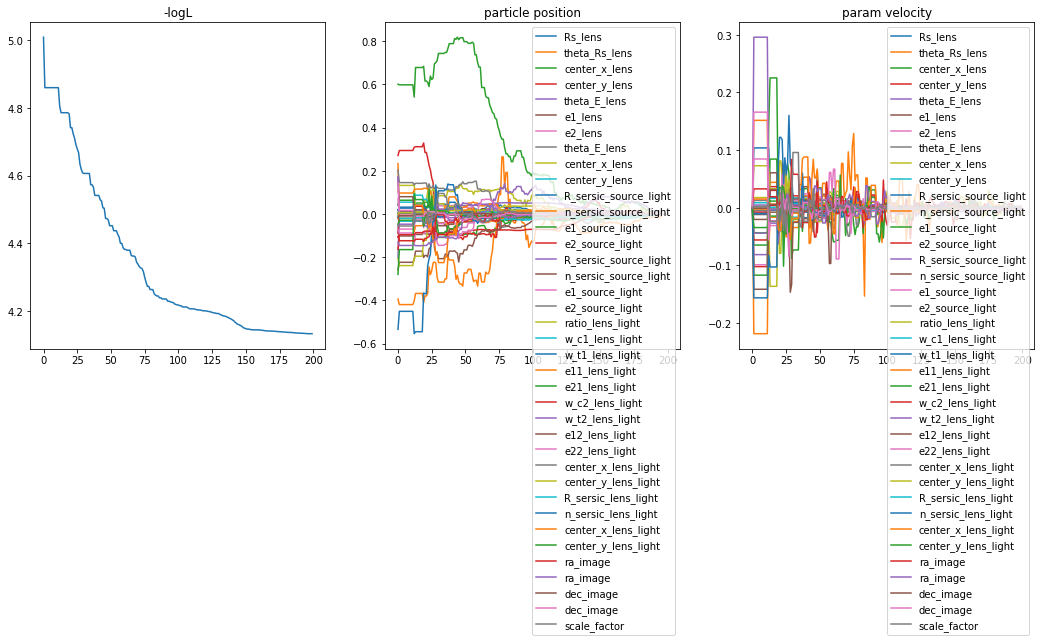

<Figure size 432x288 with 0 Axes>

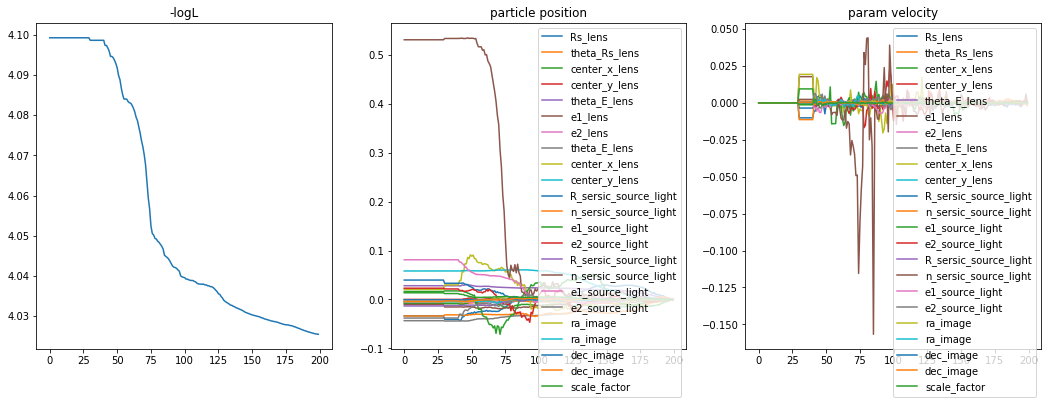

<Figure size 432x288 with 0 Axes>

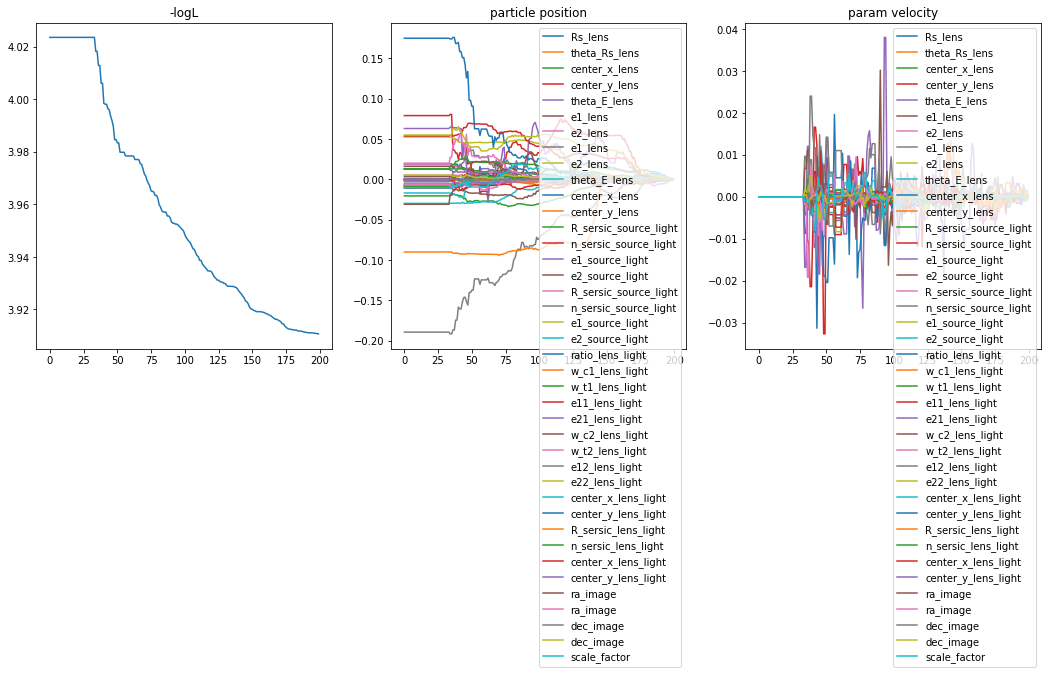

<Figure size 432x288 with 0 Axes>

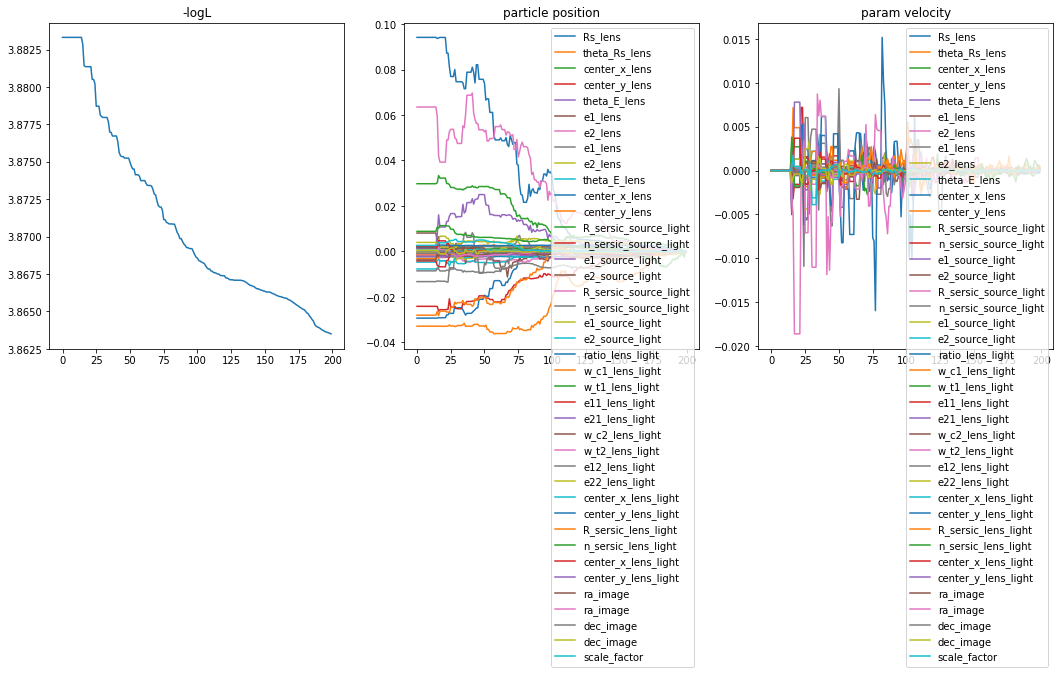

<Figure size 432x288 with 0 Axes>

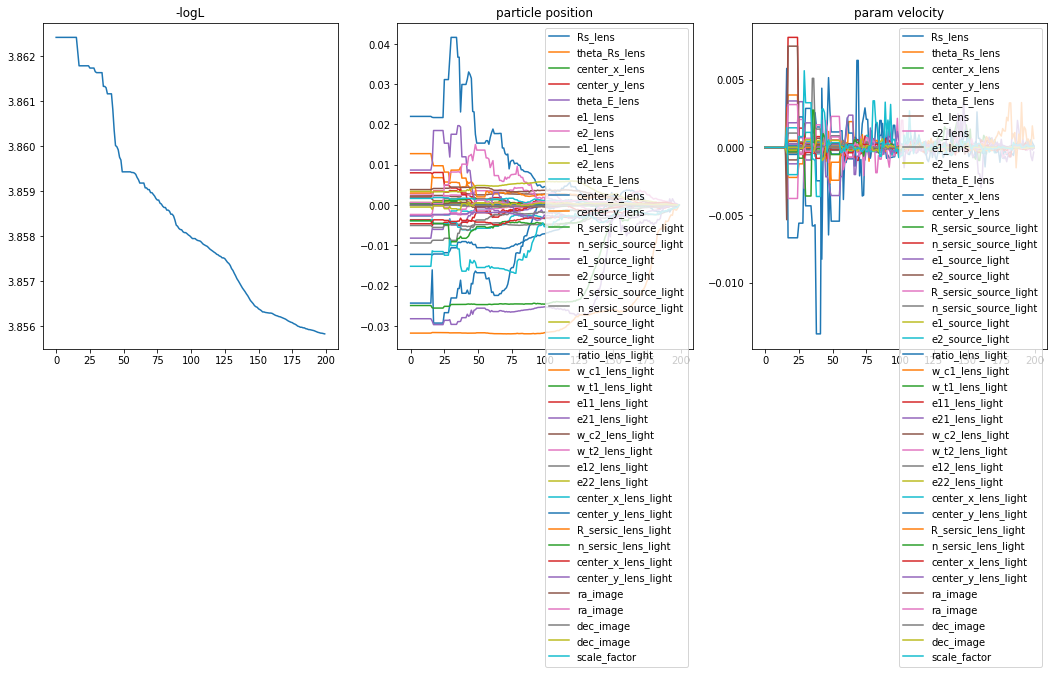

<Figure size 432x288 with 0 Axes>

In [8]:
analyse_output = True

if analyse_output:
    job_name_out = 'test'
    hoffman2_out = False
    input_temp = os.path.join(base_path, 'Temp', job_name_out +'.txt')
    output_temp = os.path.join(base_path, 'Temp', job_name_out +'_out.txt')

    if hoffman2_out is True:
        path2output_cluster = os.path.join(dir_path_cluster, output_temp)
        os_command_output = "scp "+ssh_command+":"+path2output_cluster + " " + output_temp
        print(os_command_output)
        os.system(os_command_output)

    f = open(output_temp, 'rb')
    [input_, output_] = pickle.load(f)
    f.close()
    fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc, kwargs_params_out = output_
    print(lens_result, source_result, lens_light_result, ps_result)
    for i in range(len(chain_list)):
        if len(param_list[i]) > 0:
            f, axes = out_plot.plot_chain(chain_list[i], param_list[i])


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:217: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:754: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin='lower', **kwargs)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:768: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin='lower', **kwargs)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:248: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plo

reduced chi^2 =  1.644450346652626


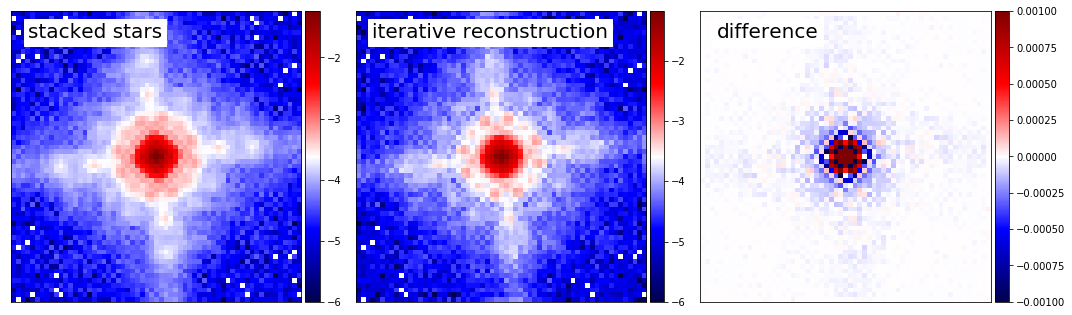

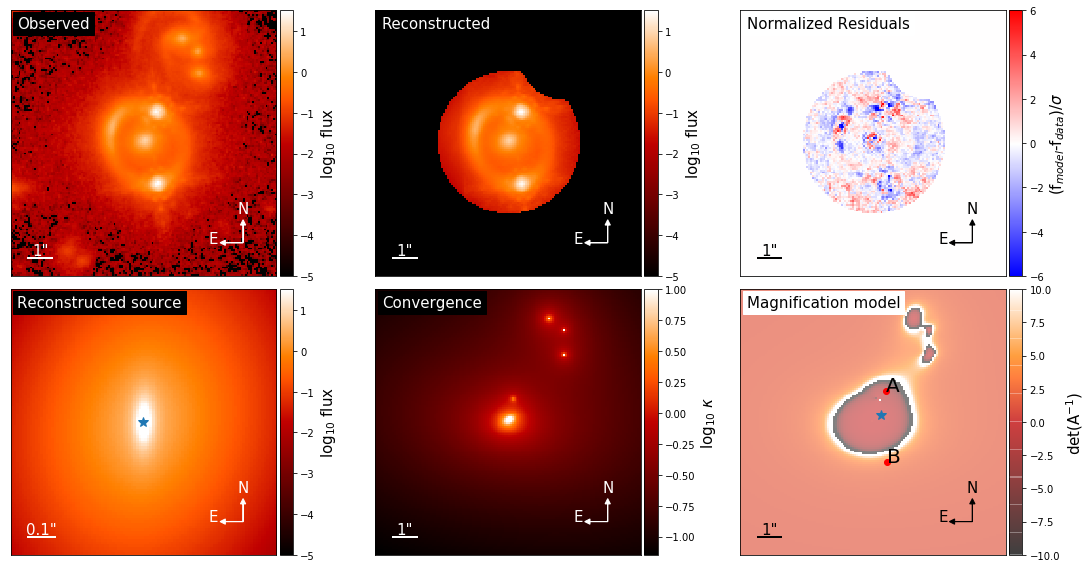

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:541: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


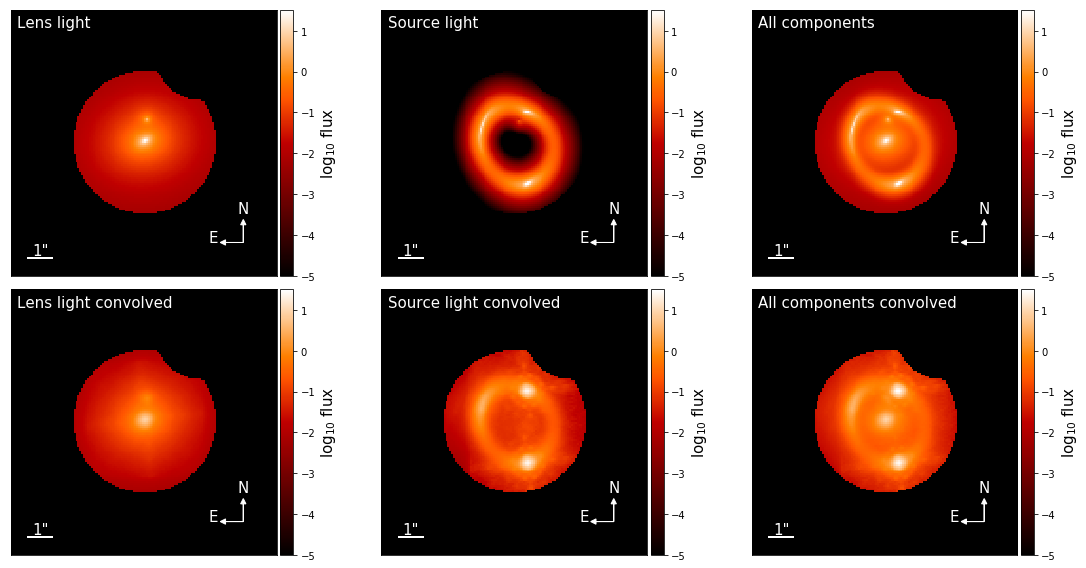

[{'Rs': 5.024073445032067, 'theta_Rs': 0.7103442599944014, 'e1': 0.16578507767175404, 'e2': 0.039647235729847644, 'center_x': 0.003486581144864188, 'center_y': -0.19996859952716975}, {'theta_E': 0.9398732437095613, 'ratio': 1.3436465335582555, 'w_c1': 0.155178490787383, 'w_t1': 0.026713863951339928, 'e11': 0.08669188398305298, 'e21': -0.15651558764077902, 'w_c2': 0.47257956107323595, 'w_t2': 0.5660057779304656, 'e12': 0.09523751364954909, 'e22': -0.008216400609027162, 'center_x': -0.0009137646504526828, 'center_y': 0.05616269260252516}, {'e1': 0.008020738868800099, 'e2': 0.050796106304318064, 'ra_0': 0, 'dec_0': 0}, {'e1': -0.0033835662576685017, 'e2': 0.0021735954100041213, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.1925138708641463, 'center_x': -2.32019894, 'center_y': 2.79985456}, {'theta_E': 0.1086059124857057, 'center_x': -2.32019933, 'center_y': 3.83985426}, {'theta_E': 0.315981592075466, 'center_x': -1.68019931, 'center_y': 4.31985428}, {'theta_E': 0.17030876824555854, 'center_x': -0

In [9]:
if analyse_output:
    
    band_i = 0
    from lenstronomy.Plots.output_plots import LensModelPlot
    import lenstronomy.Plots.output_plots as out_plot
    kwargs_data, kwargs_psf, kwargs_numerics = multi_band_list_out[band_i]
    lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = out_plot.psf_iteration_compare(kwargs_psf, vmin=-6)
    f.show()
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.data_plot(ax=axes[0,0])
    lensPlot.model_plot(ax=axes[0,1])
    lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
    lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
    lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
    lensPlot.magnification_plot(ax=axes[1, 2])
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
    lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
    lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
    lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    print(lens_result, source_result, lens_light_result, ps_result)


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/output_plots.py:563: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


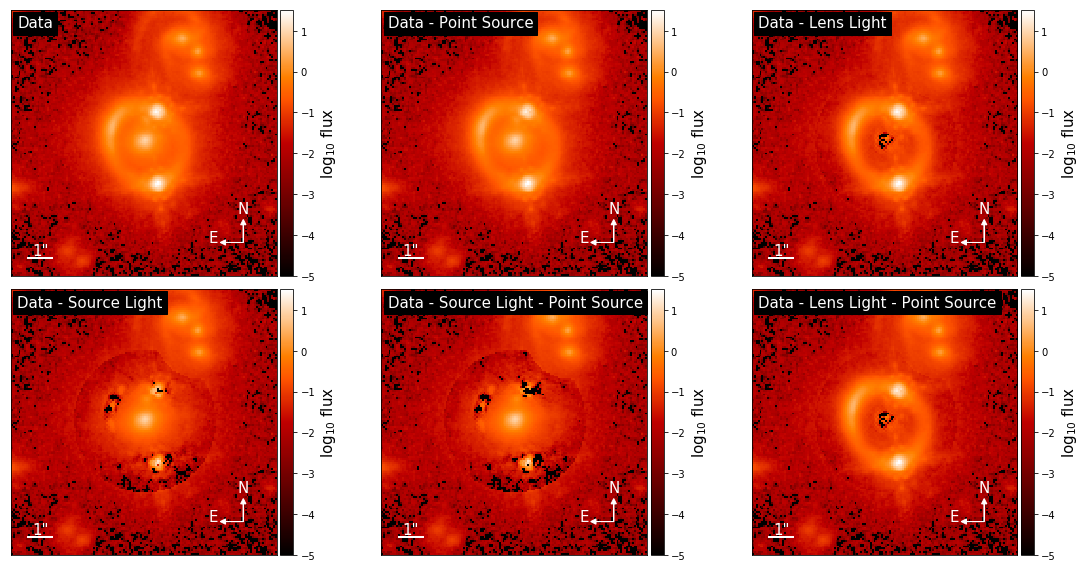

In [10]:
if True:

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.subtract_from_data_plot(ax=axes[0,0], text='Data')
    lensPlot.subtract_from_data_plot(ax=axes[0,1], text='Data - Point Source', point_source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[0,2], text='Data - Lens Light', lens_light_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,0], text='Data - Source Light', source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,1], text='Data - Source Light - Point Source', source_add=True, point_source_add=True)
    lensPlot.subtract_from_data_plot(ax=axes[1,2], text='Data - Lens Light - Point Source', lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

In [11]:
# plot mass profile

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


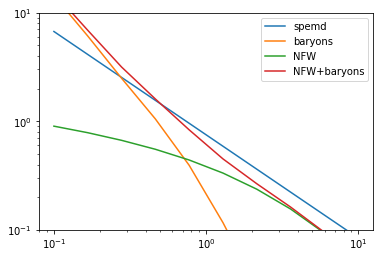

In [15]:
from lenstronomy.LensModel.lens_model import LensModel
lensModel_spemd = LensModel(lens_model_list=['SPEMD'])
kwargs_spemd = [{'theta_E': 1.3343678287375182, 'gamma': 1.95, 'e1': 0.08887638921602778, 'e2': -0.012277545103643931, 'center_x': 0, 'center_y': 0}]  # 'center_x': 0.0023485289733557293, 'center_y': -0.03187851029010698

lensModel_dm = LensModel(lens_model_list=['NFW_ELLIPSE'])
kwargs_dm = [{'Rs': 4.274422973046136, 'theta_Rs': 1.4631996070248465, 'e1': 0.043204873700764694, 'e2': -0.00420187875687184, 'center_x': 0, 'center_y': 0}] # 'center_x': -0.0030071646086290886, 'center_y': -0.07217889031724639]
lensModel_bar = LensModel(lens_model_list=['DOUBLE_CHAMELEON'])
kwargs_bar = [{'theta_E': 0.2394948938516918, 'ratio': 2.2043463261648557, 'w_c1': 0.0010132131389243876, 'w_t1': 0.22822542320553943, 'e11': 0.0035519658020293932, 'e21': -0.12501170631717853, 'w_c2': 0.13053855615555918, 'w_t2': 1.0264054020043158, 'e12': 0.2080472639916996, 'e22': -0.020926553508500565, 'center_x': 0, 'center_y': 0}]


kwargs_dm = [{'Rs': 5.024073445032067, 'theta_Rs': 0.7103442599944014, 'e1': 0.16578507767175404, 'e2': 0.039647235729847644, 'center_x': 0, 'center_y': 0}]
kwargs_bar = [{'theta_E': 0.9398732437095613, 'ratio': 1.3436465335582555, 'w_c1': 0.155178490787383, 'w_t1': 0.026713863951339928, 'e11': 0.08669188398305298, 'e21': -0.15651558764077902, 'w_c2': 0.47257956107323595, 'w_t2': 0.5660057779304656, 'e12': 0.09523751364954909, 'e22': -0.008216400609027162, 'center_x': 0, 'center_y': 0}]

r = np.logspace(-1, 1, 10)
print(r)

kappa_spemd = lensModel_spemd.kappa(r, 0, kwargs_spemd)
kappa_dm = lensModel_dm.kappa(r,  0, kwargs_dm)
kappa_bar = lensModel_bar.kappa(r,  0, kwargs_bar)

plt.loglog(r, kappa_spemd, label='spemd')
plt.loglog(r, kappa_bar, label='baryons')
plt.loglog(r, kappa_dm, label='NFW')
plt.loglog(r, kappa_dm + kappa_bar, label='NFW+baryons')
plt.legend()
plt.ylim([0.1, 10])
plt.show()